# Stream Analysis Flow (Professional V2)
This notebook processes YouTube transcripts and live chat logs to analyze engagement, spikes, and keywords.

**Refactored for:** Robust configuration, safe data slicing, and cleaner execution flow.

## 1. Workspace Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import median_abs_deviation
import re
import nltk
from nltk.corpus import stopwords
import textwrap
import os

# Optional: Interactive plotting
try:
    import plotly.express as px
    HAS_PLOTLY = True
except ImportError:
    HAS_PLOTLY = False

# Custom modules (Ensure these exist in your directory)
import src.parsers as parsers
import twitch_client 

# Pre-download NLTK data
try:
    nltk.download("stopwords", quiet=True)
    stops = set(stopwords.words("english"))
except Exception as e:
    print(f"Warning: Could not download NLTK stopwords: {e}")
    stops = set()

# Chart styling
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# --- HELPER FUNCTIONS ---
def extract_transcript_by_minutes(transcript_df, minutes):
    """
    Retrieves subtitle text for specific minutes.
    """
    if isinstance(minutes, (int, float)):
        minutes = [int(minutes)]
        
    results = {}
    for m in minutes:
        start_sec = m * 60
        end_sec = (m + 1) * 60
        
        mask = (transcript_df['offset_start_seconds'] >= start_sec) & \
               (transcript_df['offset_start_seconds'] < end_sec)
               
        segment = transcript_df[mask]
        if not segment.empty:
            text = " ".join(segment['text'].tolist())
            results[m] = text.strip()
        else:
            results[m] = "(No speech detected)"
            
    return results

def convert_time(seconds, format_type="readable", fps=60):
    """
    Unified time conversion utility.
    """
    if format_type == "timecode":
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        secs = int(seconds % 60)
        frames = int((seconds % 1) * fps)
        return f"{hours:02d}:{minutes:02d}:{secs:02d}:{frames:02d}"
    elif format_type == "readable":
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        secs = int(seconds % 60)
        if hours > 0:
            return f"{hours:02d}:{minutes:02d}:{secs:02d}"
        else:
            return f"{minutes:02d}:{secs:02d}"
    else:
        raise ValueError(f"Unknown format_type: {format_type}")

def get_seconds_from_tuple(tup):
    """Helper to convert (H, M, S) tuple to total seconds."""
    if not tup: return 0
    return tup[0]*3600 + tup[1]*60 + tup[2]

In [3]:
# === CONFIGURATION SECTION ===

# 1. Source Settings
TWITCH_URL = "https://www.twitch.tv/videos/2648216033"
TWITCH_ID = TWITCH_URL.split("/")[-1].split("?")[0]
VIDEO_OUTPUT_DIR = f"./data/{TWITCH_ID}"
os.makedirs(VIDEO_OUTPUT_DIR, exist_ok=True)

# 2. Time Slicing (Set to None to analyze full video)
# Format: (Hours, Minutes, Seconds)
#SLICE_START = None
#SLICE_END = None
SLICE_START = (2, 30, 0) 
SLICE_END = (8, 0, 0)

# 3. Text Cleanup (Specific corrections for this streamer/context)
# List of tuples: (Original, Replacement)
TEXT_REPLACEMENTS = [
    ("Faze", "Phase"),
    ("&gt;&gt; ", ""),
    ("Cleo", "Clio"),
]

# 4. Analysis Parameters
TARGET_KEYWORDS = ["lmao", "lol", "wow", "gg", "kekw", "wtf", "fuck", "clioaikekw", "clioaiicant", "clioaibark", "clioaiplus2", "clioaiminus2", "clioaiKekpoint"]
MIN_HIT_THRESHOLD = 5
PEAK_THRESHOLD_MULTIPLIER = 2.0
HIGHLIGHT_THRESHOLD_MULTIPLIER = 1.5

# 5. Boundary Detection & Highlights
BOUNDARY_START_THRESHOLD = 0.7
BOUNDARY_END_THRESHOLD = 0.8
HIGHLIGHT_ACTIVITY_WEIGHT = 0.7
HIGHLIGHT_SENTIMENT_WEIGHT = 0.3

# 6. Export Settings
FPS = 60
EDL_PADDING_MINUTES = 5

# Validation
if not TWITCH_URL or not TWITCH_ID:
    raise ValueError("YouTube URL and ID must be specified")
if not TARGET_KEYWORDS:
    raise ValueError("At least one target keyword must be specified")

print(f"Targeting Video ID: {TWITCH_ID}")
print(f"Analysis Slice: {SLICE_START if SLICE_START else 'Start'} to {SLICE_END if SLICE_END else 'End'}")
print("Configuration validation passed ✓")

Targeting Video ID: 2648216033
Analysis Slice: (2, 30, 0) to (8, 0, 0)
Configuration validation passed ✓


## 2. Download, Parse & Clean Data

In [4]:
# Download source materials
# transcript_filepath = twitch_client.download_transcript(TWITCH_ID)
chat_filepath = twitch_client.download_chat(TWITCH_ID)

# Parse DataFrames
parsed_transcript_df = pd.DataFrame()
parsed_chat_df = pd.DataFrame()

# Initialize critical variables to prevent Scope Errors later
highlight_minutes = []
start_time_seconds = 0

# if transcript_filepath:
#     parsed_transcript_df = parsers.parse_transcript_vtt(transcript_filepath)
#     # Apply Configured Text Replacements immediately
#     if not parsed_transcript_df.empty and TEXT_REPLACEMENTS:
#         print(f"Applying {len(TEXT_REPLACEMENTS)} text replacements to transcript...")
#         for original, replace in TEXT_REPLACEMENTS:
#             parsed_transcript_df['text'] = parsed_transcript_df['text'].str.replace(original, replace, regex=False)
# else:
#     print(f"No transcript available for: {TWITCH_ID}")

if chat_filepath:
    parsed_chat_df = parsers.parse_twitch_chat_json(chat_filepath)
else:
    print(f"No live chat available for: {TWITCH_ID}")

# Display Info
print("\n--- Transcript Info ---")
parsed_transcript_df.info()
print("\n--- Chat Info ---")
parsed_chat_df.info()

Attempting to download chat for VOD ID: 2648216033
Found already existing file in /tmp/twitch_chat_2648216033.json.
Parsing Twitch chat JSON: /tmp/twitch_chat_2648216033.json
Parsed 5437 Twitch chat messages.

--- Transcript Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame

--- Chat Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5437 entries, 0 to 5436
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   offset_seconds  5437 non-null   int64 
 1   minute          5437 non-null   int64 
 2   offset_text     5437 non-null   object
 3   author_name     5437 non-null   object
 4   message         5437 non-null   object
 5   bits_spent      5437 non-null   int64 
 6   user_color      4556 non-null   object
 7   created_at      5437 non-null   object
dtypes: int64(3), object(5)
memory usage: 339.9+ KB


In [5]:
# === ROBUST TIME SLICING ===

# Calculate slice boundaries in seconds
start_seconds = get_seconds_from_tuple(SLICE_START) if SLICE_START else 0
end_seconds = get_seconds_from_tuple(SLICE_END) if SLICE_END else float('inf')

start_time_seconds = start_seconds # Store for EDL export offset

if SLICE_START or SLICE_END:
    print(f"Filtering data from {convert_time(start_seconds)} to {convert_time(end_seconds) if end_seconds != float('inf') else 'End'}...")

    # Apply Slice to Transcript
    if not parsed_transcript_df.empty:
        t_mask = (parsed_transcript_df['offset_start_seconds'] >= start_seconds) & \
                 (parsed_transcript_df['offset_start_seconds'] < end_seconds)
        parsed_transcript_df = parsed_transcript_df[t_mask].copy()

    # Apply Slice to Chat
    if not parsed_chat_df.empty:
        # Convert seconds to minutes for chat filtering logic (which usually relies on 'minute' column)
        start_min = start_seconds // 60
        end_min = end_seconds // 60
        
        c_mask = (parsed_chat_df['minute'] >= start_min) & \
                 (parsed_chat_df['minute'] < end_min)
        parsed_chat_df = parsed_chat_df[c_mask].copy()

    print(f"Data sliced. Transcript rows: {len(parsed_transcript_df)}, Chat rows: {len(parsed_chat_df)}")
else:
    print("Processing Full Video (No Slicing applied).")

Filtering data from 02:30:00 to 08:00:00...
Data sliced. Transcript rows: 0, Chat rows: 3341


## 3. General Activity Analysis

In [6]:
if not parsed_chat_df.empty:
    # Aggregate by minute
    messages_per_minute = parsed_chat_df.groupby("minute").size().rename("message_count").reset_index()
    
    if not messages_per_minute.empty:
        counts = messages_per_minute["message_count"].values
        
        # Robust Peak Detection
        baseline = np.median(counts)
        mad = median_abs_deviation(counts)
        if mad == 0: mad = 1 # Prevent division by zero
        
        threshold = baseline + mad
        peaks, _ = find_peaks(counts, height=threshold)
        peak_minutes = messages_per_minute.loc[peaks, "minute"].tolist()

        # Visualization (Interactive or Static)
        if HAS_PLOTLY:
            fig = px.bar(messages_per_minute, x='minute', y='message_count', 
                         title=f'Chat Volume (Peaks > {int(threshold)})', 
                         color_discrete_sequence=['skyblue'])
            fig.add_hline(y=threshold, line_dash="dash", line_color="salmon", annotation_text="Peak Threshold")
            fig.show()
        else:
            plt.figure(figsize=(15, 6))
            bars = plt.bar(messages_per_minute['minute'], messages_per_minute['message_count'], color='skyblue')
            plt.axhline(threshold, color='salmon', linestyle='--', label=f'Threshold ({int(threshold)})')
            
            # Highlight peaks
            for p_idx in peaks:
                bars[p_idx].set_color('salmon')
                
            plt.title('Chat Volume per Minute')
            plt.xlabel('Minute')
            plt.ylabel('Count')
            plt.legend()
            plt.show()
    else:
        print("No chat messages found in the selected slice.")
else:
    print("Skipping analysis: No chat data.")

## 4. User Analysis

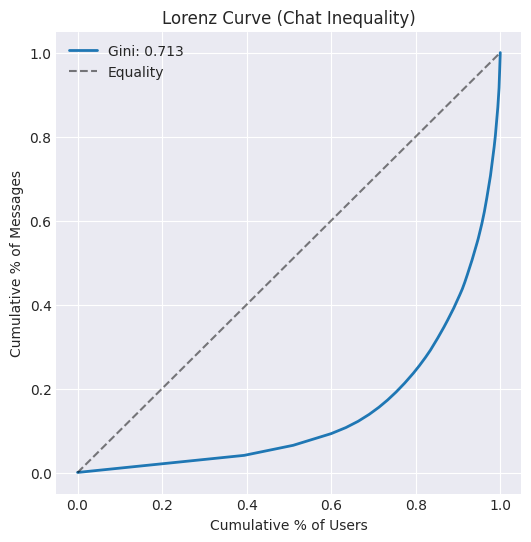

Top 5 Chatters:
        author_name  msg_count
0       Chudstorian        281
1      thealpha_tau        153
2           Naalive        114
3  myfriendtheearth        112
4       Spartan7712         90


In [7]:
if not parsed_chat_df.empty:
    user_counts = parsed_chat_df["author_name"].value_counts().reset_index()
    user_counts.columns = ["author_name", "msg_count"]

    # --- Gini & Lorenz Curve ---
    counts = user_counts["msg_count"].values
    counts_sorted = np.sort(counts)
    n = len(counts_sorted)
    
    cum_counts = np.cumsum(counts_sorted)
    if n > 0 and cum_counts[-1] > 0:
        normalized_cum_counts = cum_counts / cum_counts[-1]
        gini = (n + 1 - 2 * np.sum(cum_counts) / cum_counts[-1]) / n
    else:
        gini = 0.0
        normalized_cum_counts = [0]

    x_axis = np.linspace(0, 1, len(normalized_cum_counts))

    plt.figure(figsize=(6, 6))
    plt.plot(x_axis, normalized_cum_counts, label=f'Gini: {gini:.3f}', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Equality')
    plt.title('Lorenz Curve (Chat Inequality)')
    plt.xlabel('Cumulative % of Users')
    plt.ylabel('Cumulative % of Messages')
    plt.legend()
    plt.show()

    print(f"Top 5 Chatters:\n{user_counts.head(5)}")

## 5. Keyword & Transcript Deep Dive

In [8]:
if not parsed_chat_df.empty:
    
    print("Scanning chat for keywords...")
    chat_messages_lower = parsed_chat_df['message'].str.lower()
    keyword_hits = []
    
    for kw in TARGET_KEYWORDS:
        mask = chat_messages_lower.str.contains(kw, case=False, na=False)
        if mask.any():
            matches = parsed_chat_df[mask][['minute']].copy()
            matches['keyword'] = kw
            keyword_hits.extend(matches.to_dict('records'))
    
    df_hits = pd.DataFrame(keyword_hits)
    
    if not df_hits.empty:
        pivot_df = df_hits.groupby(['minute', 'keyword']).size().unstack(fill_value=0)
        
        # Reindex to ensure continuous timeline
        min_m, max_m = int(parsed_chat_df['minute'].min()), int(parsed_chat_df['minute'].max())
        all_minutes = range(min_m, max_m + 1)
        pivot_df = pivot_df.reindex(all_minutes, fill_value=0)

        # Plot
        if HAS_PLOTLY:
            fig = px.bar(pivot_df, barmode='stack', title=f'Keyword Frequency: {TARGET_KEYWORDS}')
            fig.show()
        else:
            pivot_df.plot(kind='bar', stacked=True, figsize=(18, 8), width=1.0, colormap='viridis')
            plt.title(f'Keyword Frequency: {TARGET_KEYWORDS}')
            plt.xlabel('Minute')
            plt.xticks([]) # Hide all ticks for cleaner view
            plt.show()
        
        # Context Extraction
        minutes_meeting_threshold = pivot_df[pivot_df.sum(axis=1) >= MIN_HIT_THRESHOLD].index.tolist()
        
        if minutes_meeting_threshold and not parsed_transcript_df.empty:
            print(f"\n--- TRANSCRIPT FOR KEYWORD SPIKES (Threshold: {MIN_HIT_THRESHOLD}+) ---")
            transcript_context = extract_transcript_by_minutes(parsed_transcript_df, minutes_meeting_threshold)
            
            for m in sorted(minutes_meeting_threshold):
                breakdown = dict(pivot_df.loc[m][pivot_df.loc[m] > 0])
                print(f"\n[Minute {m}] Keywords: {breakdown}")
                print(f"{textwrap.fill(transcript_context[m], width=80, initial_indent='  ', subsequent_indent='  ')}")
        elif not minutes_meeting_threshold:
            print(f"No minutes exceeded the keyword threshold ({MIN_HIT_THRESHOLD}).")
    else:
        print("No matches found for provided keywords.")

Scanning chat for keywords...


## 6. Automated Highlight Detection (Sentiment + Activity)

Calculating sentiment scores (this may take a moment for large chats)...


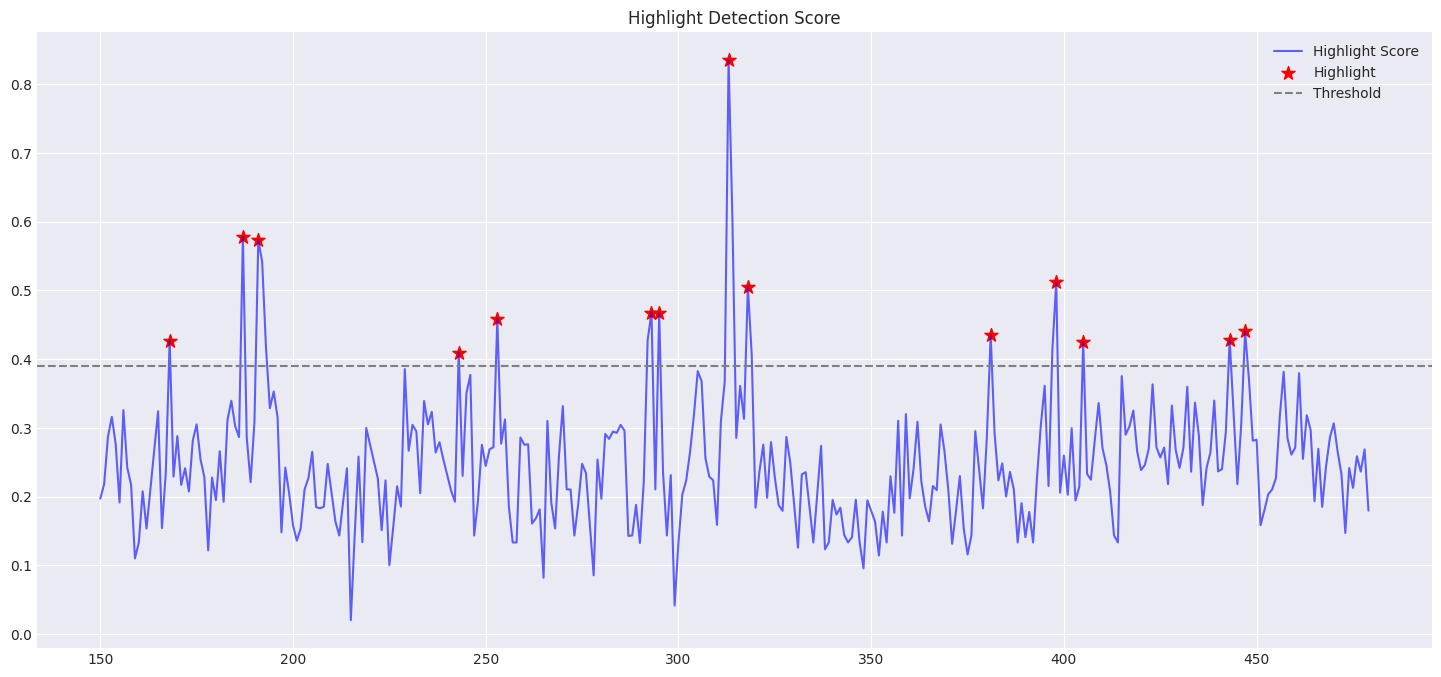

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

highlight_minutes = [] # Reset

if not parsed_chat_df.empty:
    print("Calculating sentiment scores (this may take a moment for large chats)...")
    analyzer = SentimentIntensityAnalyzer()
    
    # Note: For massive datasets (1M+ rows), consider batching this
    parsed_chat_df['sentiment'] = parsed_chat_df['message'].apply(lambda msg: analyzer.polarity_scores(str(msg))['compound'])

    # Aggregate
    metrics = parsed_chat_df.groupby('minute').agg(
        message_count=('message', 'size'),
        avg_sentiment=('sentiment', 'mean')
    ).reset_index()

    # Normalize
    def normalize(series):
        return (series - series.min()) / (series.max() - series.min())

    if not metrics.empty:
        metrics['norm_count'] = normalize(metrics['message_count'])
        metrics['norm_sent'] = normalize(metrics['avg_sentiment'])

        # Score Calculation
        metrics['highlight_score'] = (HIGHLIGHT_ACTIVITY_WEIGHT * metrics['norm_count']) + \
                                     (HIGHLIGHT_SENTIMENT_WEIGHT * metrics['norm_sent'])

        # Peak Detection
        h_threshold = metrics['highlight_score'].mean() + (HIGHLIGHT_THRESHOLD_MULTIPLIER * metrics['highlight_score'].std())
        peaks, _ = find_peaks(metrics['highlight_score'], height=h_threshold)
        highlight_minutes = metrics.loc[peaks, 'minute'].tolist()

        # Visualization
        plt.figure(figsize=(18, 8))
        plt.plot(metrics['minute'], metrics['highlight_score'], label='Highlight Score', color='blue', alpha=0.6)
        plt.scatter(metrics.loc[peaks, 'minute'], metrics.loc[peaks, 'highlight_score'], color='red', s=100, marker='*', label='Highlight')
        plt.axhline(h_threshold, color='gray', linestyle='--', label='Threshold')
        plt.title('Highlight Detection Score')
        plt.legend()
        plt.show()

        if highlight_minutes and not parsed_transcript_df.empty:
            print(f'\n--- CONTEXT FOR {len(highlight_minutes)} DETECTED HIGHLIGHTS ---')
            transcript_context = extract_transcript_by_minutes(parsed_transcript_df, highlight_minutes)
            for m in sorted(highlight_minutes):
                print(f'[Minute {m}]')
                print(f'{textwrap.fill(transcript_context[m], width=80, initial_indent="  ", subsequent_indent="  ")}')
    else:
        print("Metrics dataframe is empty.")
else:
    print("Chat data missing for highlight detection.")

## 7. Dynamic Padding (Smart Boundaries)

In [12]:
# ==========================================
#           DYNAMIC PADDING CONFIG
# ==========================================
BUILDUP_SEARCH_WINDOW = 10  
WINDDOWN_SEARCH_WINDOW = 15 
MIN_PRE_PADDING = 180  
MIN_POST_PADDING = 120 
ACTIVITY_THRESHOLD_MULTIPLIER = 1.5 
DROP_OFF_CONFIRMATION_MINS = 2
# ==========================================

def get_dynamic_segments(peaks, chat_df, baseline_median):
    segments = []
    
    # Get safe min/max from actual data
    min_min = int(chat_df['minute'].min())
    max_min = int(chat_df['minute'].max())
    
    # Reindex for continuous lookup
    counts_series = chat_df.groupby('minute').size().reindex(range(min_min, max_min + 1), fill_value=0)
    activity_threshold = baseline_median * ACTIVITY_THRESHOLD_MULTIPLIER

    for peak_min in sorted(peaks):
        peak_sec = peak_min * 60
        
        # --- 1. Find Start (Ramp-Up) ---
        start_min = peak_min
        search_start = max(min_min, peak_min - BUILDUP_SEARCH_WINDOW)
        
        for m in range(peak_min - 1, search_start - 1, -1):
            if counts_series.get(m, 0) < activity_threshold:
                start_min = m
                break
            start_min = m 
            
        dynamic_start_sec = start_min * 60
        safe_start_sec = peak_sec - MIN_PRE_PADDING
        final_start_sec = max(min_min * 60, min(dynamic_start_sec, safe_start_sec))
        
        # --- 2. Find End (Drop-Off) ---
        end_min = peak_min
        search_end = min(max_min, peak_min + WINDDOWN_SEARCH_WINDOW)
        quiet_streak = 0
        
        for m in range(peak_min + 1, search_end + 1):
            if counts_series.get(m, 0) < activity_threshold:
                quiet_streak += 1
            else:
                quiet_streak = 0
            
            if quiet_streak >= DROP_OFF_CONFIRMATION_MINS:
                end_min = m - quiet_streak + 1
                break
            end_min = m

        dynamic_end_sec = (end_min + 1) * 60
        safe_end_sec = peak_sec + MIN_POST_PADDING
        final_end_sec = max(dynamic_end_sec, safe_end_sec)
        
        segments.append((int(final_start_sec), int(final_end_sec)))

    return segments

def merge_segments(segments):
    if not segments: return []
    segments.sort(key=lambda x: x[0])
    merged = []
    current_start, current_end = segments[0]
    
    for next_start, next_end in segments[1:]:
        if next_start <= current_end + 10: # Merge if gap is small
            current_end = max(current_end, next_end)
        else:
            merged.append((current_start, current_end))
            current_start, current_end = next_start, next_end
            
    merged.append((current_start, current_end))
    return merged

# Execution
dynamic_time_ranges = []
if highlight_minutes and not parsed_chat_df.empty:
    slice_min = int(parsed_chat_df['minute'].min())
    slice_max = int(parsed_chat_df['minute'].max())
    
    counts_in_slice = parsed_chat_df.groupby('minute').size().reindex(range(slice_min, slice_max + 1), fill_value=0)
    median_rate = counts_in_slice.median()
    
    print(f"Baseline Rate: {median_rate:.1f} msgs/min | Threshold: {median_rate * ACTIVITY_THRESHOLD_MULTIPLIER:.1f}")
    
    raw_segments = get_dynamic_segments(highlight_minutes, parsed_chat_df, median_rate)
    dynamic_time_ranges = merge_segments(raw_segments)
    
    print(f"\nGenerated {len(dynamic_time_ranges)} optimized segments:")
    for i, (start, end) in enumerate(dynamic_time_ranges, 1):
        print(f"{i}. {convert_time(start)} -> {convert_time(end)} (Duration: {convert_time(end-start)})")
else:
    print("Skipping Dynamic Padding: No highlights found.")

Baseline Rate: 8.0 msgs/min | Threshold: 12.0

Generated 10 optimized segments:
1. 02:45:00 -> 02:50:00 (Duration: 05:00)
2. 03:02:00 -> 03:18:00 (Duration: 16:00)
3. 04:00:00 -> 04:08:00 (Duration: 08:00)
4. 04:10:00 -> 04:17:00 (Duration: 07:00)
5. 04:50:00 -> 04:57:00 (Duration: 07:00)
6. 05:10:00 -> 05:21:00 (Duration: 11:00)
7. 06:18:00 -> 06:24:00 (Duration: 06:00)
8. 06:35:00 -> 06:40:00 (Duration: 05:00)
9. 06:42:00 -> 06:47:00 (Duration: 05:00)
10. 07:20:00 -> 07:32:00 (Duration: 12:00)


# 8. Output
- edl for davinci resolve
- export srt file from transcript dataframe
- download video clips from highlights
- export csv file from chat dataframe

In [43]:
#               EDL EXPORT
# ==========================================
# If SOURCE_MATCHES_SLICE is True, the EDL assumes the source video starts at 00:00 relative to the slice.
# If False, it assumes source video is the full original stream.
SOURCE_MATCHES_SLICE = True

OUTPUT_EDL_PATH = f"{VIDEO_OUTPUT_DIR}/highlights_{TWITCH_ID}.edl"

def seconds_to_timecode(seconds, fps=FPS):
    return convert_time(seconds, "timecode", fps)

def generate_edl(ranges, output_filename, offset_seconds):
    if not ranges:
        print("No ranges to export.")
        return

    # Offset Logic
    # If the user has a trimmed clip, we subtract the start_time_seconds from the absolute time
    # to get the relative time in the clip.
    calc_offset = offset_seconds if SOURCE_MATCHES_SLICE else 0
    
    mode_str = "Trimmed Clip" if SOURCE_MATCHES_SLICE else "Full Stream"
    print(f"Generating EDL in '{mode_str}' mode. Offset: {calc_offset}s")

    edl_lines = [
        f"TITLE: Highlights_{TWITCH_ID}",
        "FCM: NON-DROP FRAME",
        ""
    ]

    current_timeline_time = 0
    
    for i, (abs_start, abs_end) in enumerate(ranges, 1):
        duration_sec = abs_end - abs_start
        
        src_in = max(0, abs_start - calc_offset)
        src_out = max(0, abs_end - calc_offset)
        
        source_start_tc = seconds_to_timecode(src_in)
        source_end_tc = seconds_to_timecode(src_out)
        timeline_start_tc = seconds_to_timecode(current_timeline_time)
        timeline_end_tc = seconds_to_timecode(current_timeline_time + duration_sec)
        
        clip_name = f"HIGHLIGHT_{i:03d}"
        edl_lines.append(f"{i:03d}  {clip_name}     V     C        {source_start_tc} {source_end_tc} {timeline_start_tc} {timeline_end_tc}")
        edl_lines.append(f"* FROM CLIP NAME: {clip_name}")
        edl_lines.append(f"* ABSOLUTE STREAM TIME: {convert_time(abs_start)} - {convert_time(abs_end)}")
        edl_lines.append("")

        current_timeline_time += duration_sec

    with open(output_filename, 'w', encoding='utf-8') as f:
        f.write('\n'.join(edl_lines))
    
    print(f"✓ Saved EDL to: {output_filename}")

# Run
if dynamic_time_ranges:
    generate_edl(dynamic_time_ranges, OUTPUT_EDL_PATH, start_time_seconds)
else:
    print("No dynamic ranges available for export.")

Generating EDL in 'Trimmed Clip' mode. Offset: 9000s
✓ Saved EDL to: ./data/2648216033/highlights_2648216033.edl


In [44]:
def dataframe_to_srt(df, output_path, ref_start_seconds=0, ref_end_seconds=None):
    """
    Convert transcript DataFrame to SRT Format with relative timing and clamping.
    
    Args:
        df: DataFrame containing the transcript rows.
        output_path: Destination file path.
        ref_start_seconds: The absolute start time of the clip. 
                           Subtitles will be shifted so this timestamp becomes 00:00:00.
        ref_end_seconds: The absolute end time of the clip. 
                         Subtitles extending past this will be clamped/cut off.
    """
    if df.empty:
        return False
        
    def seconds_to_srt_time(seconds):
        # Helper to format seconds to HH:MM:SS,mmm
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        secs = int(seconds % 60)
        milliseconds = int((seconds % 1) * 1000)
        return f"{hours:02d}:{minutes:02d}:{secs:02d},{milliseconds:03d}"

    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            counter = 1
            for _, row in df.iterrows():
                # 1. Calculate Absolute Times
                abs_start = row['offset_start_seconds']
                abs_end = row['offset_end_seconds']

                # 2. Skip if completely out of bounds (redundant if filtered, but safe)
                if ref_end_seconds and abs_start >= ref_end_seconds:
                    continue
                if abs_end <= ref_start_seconds:
                    continue

                # 3. Calculate Relative Times (Shifted)
                rel_start = abs_start - ref_start_seconds
                rel_end = abs_end - ref_start_seconds

                # 4. Clamp Boundaries
                # If subtitle starts before clip, set to 0
                if rel_start < 0: 
                    rel_start = 0
                
                # If subtitle ends after clip, cap it at the clip duration
                if ref_end_seconds:
                    clip_duration = ref_end_seconds - ref_start_seconds
                    if rel_end > clip_duration:
                        rel_end = clip_duration

                # 5. Write to File
                # Only write if there is a valid duration (start < end)
                if rel_end > rel_start:
                    start_str = seconds_to_srt_time(rel_start)
                    end_str = seconds_to_srt_time(rel_end)
                    
                    f.write(f"{counter}\n")
                    f.write(f"{start_str} --> {end_str}\n")
                    f.write(f"{row['text']}\n\n")
                    counter += 1
        return True
    except Exception as e:
        print(f"Error exporting SRT {output_path}: {e}")
        return False

In [45]:
# --- Configuration ---
# Toggle to actually download video (False = Generate SRT/CSV only)
VIDEO_CLIP_DOWNLOAD = True
# True: Downloads separate video files for each highlight.
# False: Downloads one single video from the start of the first highlight to the end of the last.
DOWNLOAD_IN_SECTIONS = True
# Overwrite files if they already exist?
OVERWRITE_EXISTING = False

In [ ]:
# ==========================================
#        EXPORT CONFIGURATION & SETUP
# ==========================================
import os

# --- Core Export Logic ---
def process_export_job(job_name, start_sec, end_sec, output_dir):
    """
    Handles the generation of Video, SRT, and CSV for a specific time range.
    Returns a summary string of actions taken.
    """
    actions_taken = []
    
    # 1. Define File Paths
    section_name = f"{job_name}_{convert_time(start_sec).replace(':', '_')}_{convert_time(end_sec).replace(':', '_')}"
    video_path = os.path.join(output_dir, f"{section_name}.mp4")
    srt_path = os.path.join(output_dir, f"{section_name}.srt")
    csv_path = os.path.join(output_dir, f"{section_name}_chat.csv")

    # 2. Video Download
    if VIDEO_CLIP_DOWNLOAD:
        if not os.path.exists(video_path) or OVERWRITE_EXISTING:
            try:
                # Assuming youtube_client accepts a list of tuples for sections
                # We pass just one section for this specific job
                time_range = [(convert_time(start_sec), convert_time(end_sec))]
                
                twitch_client.download_video(
                    TWITCH_ID, 
                    output_dir=output_dir, 
                    video_name=job_name, 
                    download_sections=time_range
                )
                actions_taken.append("Video Downloaded")
            except Exception as e:
                print(f"  [!] Video Error: {e}")
        else:
            actions_taken.append("Video Exists (Skipped)")

    # 3. SRT Generation
    # We use the previously defined 'dataframe_to_srt'
    if not parsed_transcript_df.empty:
        # Filter transcript to the job's range
        t_mask = (parsed_transcript_df['offset_end_seconds'] > start_sec) & \
                 (parsed_transcript_df['offset_start_seconds'] < end_sec)
        job_transcript = parsed_transcript_df[t_mask].copy()
        
        if not job_transcript.empty:
            success = dataframe_to_srt(
                job_transcript, 
                srt_path, 
                ref_start_seconds=start_sec, # 00:00 in SRT will equal start_sec
                ref_end_seconds=end_sec
            )
            if success: actions_taken.append("SRT Generated")
    
    # 4. Chat CSV Export
    if not parsed_chat_df.empty:
        # Filter chat to the job's range
        c_mask = (parsed_chat_df['offset_seconds'] >= start_sec) & \
                 (parsed_chat_df['offset_seconds'] < end_sec)
        job_chat = parsed_chat_df[c_mask].copy()
        
        if not job_chat.empty:
            # Normalize time relative to the clip start
            job_chat['relative_seconds'] = job_chat['offset_seconds'] - start_sec
            
            # Select and rename columns for clean output
            export_cols = {
                'relative_seconds': 'time_offset',
                'author_name': 'user',
                'message': 'message'
            }
            # Include superchat if available
            if 'superchat_amount' in job_chat.columns:
                export_cols['superchat_amount'] = 'amount'
                
            csv_data = job_chat.rename(columns=export_cols)[export_cols.values()]
            csv_data['time_offset'] = csv_data['time_offset'].round(2)
            
            csv_data.to_csv(csv_path, index=False, encoding='utf-8')
            actions_taken.append(f"Chat CSV ({len(job_chat)} msgs)")

    return ", ".join(actions_taken) if actions_taken else "No actions (Data missing or files exist)"

In [ ]:
# ==========================================
#             BATCH PROCESSING
# ==========================================

if 'dynamic_time_ranges' in locals() and dynamic_time_ranges:
    
    export_jobs = []

    # --- Scenario A: Download Sections (Separate Clips) ---
    if DOWNLOAD_IN_SECTIONS:
        print(f"Mode: Multi-Section Export ({len(dynamic_time_ranges)} clips)")
        for i, (start, end) in enumerate(dynamic_time_ranges, 1):
            export_jobs.append({
                "name": f"HIGHLIGHT_{TWITCH_ID}_{convert_time(start).replace(':', '_')}_{convert_time(end).replace(':', '_')}",
                "start": start,
                "end": end,
                "desc": f"Clip {i}"
            })

    # --- Scenario B: Download Combined (Single Range) ---
    else:
        # Determine the full span from the first highlight start to the last highlight end
        full_start = start_seconds if start_seconds else None
        full_end = end_seconds if end_seconds else None

        print(f"Mode: Combined Export (Span: {convert_time(full_start)} - {convert_time(full_end)})")
        export_jobs.append({
            "name": f"FULL_SESSION_{TWITCH_ID}_{convert_time(full_start).replace(':', '_')}_{convert_time(full_end).replace(':', '_')}",
            "start": full_start,
            "end": full_end,
            "desc": "Full Highlight Span"
        })

    # --- Execute Jobs ---
    print(f"\nProcessing {len(export_jobs)} job(s)...")
    print("-" * 60)

    for i, job in enumerate(export_jobs, 1):
        print(f"[{i}/{len(export_jobs)}] {job['desc']}...", end=" ", flush=True)
        
        try:
            result_summary = process_export_job(
                job_name=job['name'],
                start_sec=job['start'],
                end_sec=job['end'],
                output_dir=VIDEO_OUTPUT_DIR
            )
            print(f"DONE. [{result_summary}]")
        except Exception as e:
            print(f"FAILED.\n    Error: {str(e)}")

    print("-" * 60)
    print("Export Complete.")

else:
    print("Skipping Export: No 'dynamic_time_ranges' found. Please run the analysis cells first.")

Mode: Multi-Section Export (10 clips)

Processing 10 job(s)...
------------------------------------------------------------
[1/10] Clip 1... Attempting to download video for VOD ID: 2648216033
Section download requested from 02:45:00 to 02:50:00
Note: TwitchDownloaderCLI may not support time-based section downloads
  [RUNNING COMMAND]: /usr/bin/TwitchDownloaderCLI videodownload --id 2648216033 -o ./data/2648216033/HIGHLIGHT_2648216033_001_02_45_00_02_50_00.mp4 --beginning 02:45:00 --ending 02:50:00
Video downloaded to: ./data/2648216033/HIGHLIGHT_2648216033_001_02_45_00_02_50_00.mp4
DONE. [Video Downloaded, Chat CSV (64 msgs)]
[2/10] Clip 2... Attempting to download video for VOD ID: 2648216033
Section download requested from 03:02:00 to 03:18:00
Note: TwitchDownloaderCLI may not support time-based section downloads
  [RUNNING COMMAND]: /usr/bin/TwitchDownloaderCLI videodownload --id 2648216033 -o ./data/2648216033/HIGHLIGHT_2648216033_002_03_02_00_03_18_00.mp4 --beginning 03:02:00 --e